In [38]:
import Pkg
Pkg.activate("../../")

  Activating project at `~/Documents/MPSTime.jl`


In [290]:
using DelimitedFiles
using Plots
using MPSTime
using ProgressMeter
using Normalization
using StatsPlots
using StatsBase
using PrettyTables
using LaTeXStrings
using Plots.PlotMeasures
using ITensors
using JLD2

# UCR Anomaly Dataset Exploration

In [10]:
dpath = "../UCR_Data"
datasets = filter(file -> endswith(file, ".txt"), readdir(dpath));
println("Loaded $(length(datasets)) datasets")

Loaded 250 datasets


In [101]:
function get_basic_stats(fname::String)
    data_f = readdlm("../UCR_Data/" *fname)
    fname_split = split.(split(fname, "_"), ".")
    dname = fname_split[4][1]
    train_end = parse(Int, fname_split[5][1])
    train_length = length(1:train_end)
    test_length = length(train_end+1:length(data_f))
    anomaly_length = parse(Int, fname_split[7][1]) - parse(Int, fname_split[6][1])
    return dname, train_length, test_length, anomaly_length
end

get_basic_stats (generic function with 1 method)

In [74]:
all_stats = get_basic_stats.(datasets);

In [78]:
anom_length_dists = [last(all_stats[i]) for i in eachindex(all_stats)];
train_length_dists = [all_stats[i][2] for i in eachindex(all_stats)];
test_length_dists = [all_stats[i][3] for i in eachindex(all_stats)];

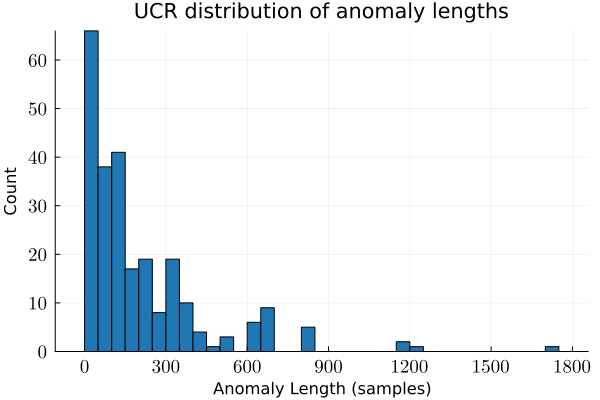

In [81]:
histogram(anom_length_dists, nbins=50, label="", xlabel="Anomaly Length (samples)", ylabel="Count", c=palette(:tab10)[1],
    xtickfont=font("Computer Modern", 12), ytickfont=font("Computer Modern", 12), title="UCR distribution of anomaly lengths",
    xticks=(0:300:2000))


In [67]:
println(length(findall(x -> x == 1, anom_length_dists)))
println(length(findall(x -> x == 5, anom_length_dists)))
println(length(findall(x -> x == 10, anom_length_dists)))
println(length(findall(x -> x > 1, anom_length_dists)))

17
1
5
230


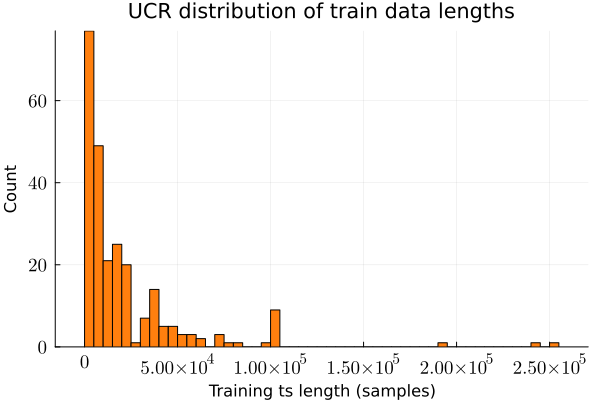

In [87]:
histogram(train_length_dists, nbins=50, label="", xlabel="Training ts length (samples)", ylabel="Count", c=palette(:tab10)[2],
    xtickfont=font("Computer Modern", 12), ytickfont=font("Computer Modern", 12), title="UCR distribution of train data lengths")


In [99]:
@show maximum(train_length_dists);
@show minimum(train_length_dists);

maximum(train_length_dists) = 250000
minimum(train_length_dists) = 1000


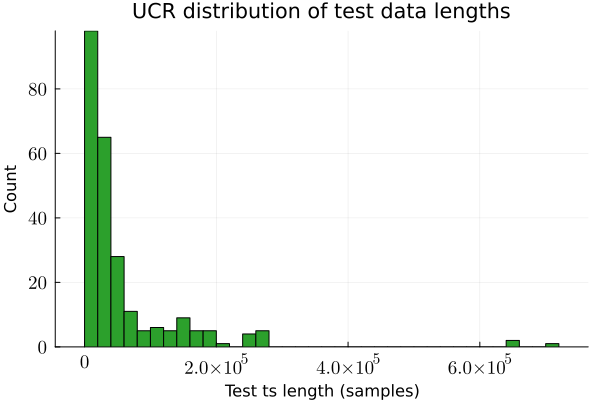

In [96]:
histogram(test_length_dists, nbins=50, label="", xlabel="Test ts length (samples)", ylabel="Count", c=palette(:tab10)[3],
    xtickfont=font("Computer Modern", 12), ytickfont=font("Computer Modern", 12), title="UCR distribution of test data lengths")


In [100]:
@show maximum(test_length_dists);
@show minimum(test_length_dists);

maximum(test_length_dists) = 707630
minimum(test_length_dists) = 3301


In [103]:
datasets[1]

"001_UCR_Anomaly_DISTORTED1sddb40_35000_52000_52620.txt"

In [107]:
data_f = readdlm("../UCR_Data/" * datasets[1])
X_train = data_f[1:35000]
X_test = data_f[35001:end];
maximum(X_train)

836.23169

In [110]:
sum(X_test .> maximum(X_train))

4

In [119]:
large_anomaly_idxs = findall(x -> x .> 1, anom_length_dists);
@show length(large_anomaly_idxs);
large_anomaly_subset = datasets[large_anomaly_idxs];

length(large_anomaly_idxs) = 230


In [121]:
num_exceeding = []
for dset in large_anomaly_subset
    data_f = readdlm("../UCR_Data/" * dset)
    fname_split = split.(split(dset, "_"), ".")
    train_end = parse(Int, fname_split[5][1])
    X_train = data_f[1:train_end]
    X_test = data_f[train_end+1:end]
    push!(num_exceeding, sum(X_test .> maximum(X_train)))
end

In [158]:
num_oob = []
for dset in large_anomaly_subset
    data_f = readdlm("../UCR_Data/" * dset)
    fname_split = split.(split(dset, "_"), ".")
    train_end = parse(Int, fname_split[5][1])
    X_train = data_f[1:train_end]
    X_test = data_f[train_end+1:end]
    num_below = sum(X_test .< minimum(X_train))
    num_above = sum(X_test .> maximum(X_train))
    total_oob = num_below + num_above
    push!(num_oob, total_oob)
end

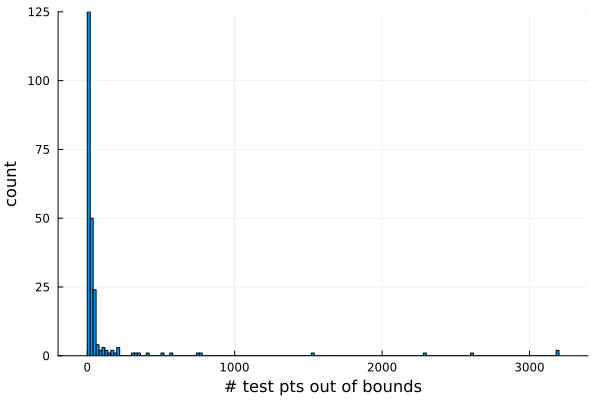

In [133]:
histogram(num_oob, label="", xlabel="# test pts out of bounds", ylabel="count")

maximum oob deviation

In [169]:
max_oob_deviation = []
for dset in large_anomaly_subset
    data_f = readdlm("../UCR_Data/" * dset)
    fname_split = split.(split(dset, "_"), ".")
    train_end = parse(Int, fname_split[5][1])
    X_train = data_f[1:train_end]
    X_test = data_f[train_end+1:end]
    max_dev_above = abs(maximum(X_train) - maximum(X_test))/(maximum(X_train) - minimum(X_train))
    max_dev_below = abs(minimum(X_train) - minimum(X_test))/(maximum(X_train) - minimum(X_train))
    push!(max_oob_deviation, max(max_dev_above, max_dev_below))
end

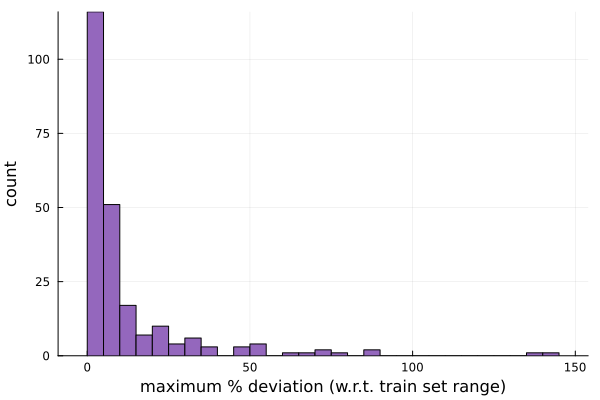

In [185]:
histogram(max_oob_deviation*100, bins=50, label="", c=palette(:tab10)[5],
    ylabel="count", xlabel="maximum % deviation (w.r.t. train set range)")

In [194]:
@show sum(max_oob_deviation .> 0.1);
@show sum(max_oob_deviation .> 0.05);
@show sum(max_oob_deviation .> 0.08);

sum(max_oob_deviation .> 0.1) = 63
sum(max_oob_deviation .> 0.05) = 114
sum(max_oob_deviation .> 0.08) = 73


In [197]:
@show sum(max_oob_deviation .<= 0.1);

sum(max_oob_deviation .<= 0.1) = 167


In [199]:
inbounds_subset_idxs = findall(x -> x .<= 0.05, max_oob_deviation)

116-element Vector{Int64}:
   1
   7
  12
  14
  18
  20
  21
  22
  23
  24
   ⋮
 215
 219
 220
 221
 222
 223
 224
 225
 226

In [201]:
inbounds_large_anom_subset = large_anomaly_subset[inbounds_subset_idxs];

In [202]:
for d in inbounds_large_anom_subset
    println(d)
end

001_UCR_Anomaly_DISTORTED1sddb40_35000_52000_52620.txt
008_UCR_Anomaly_DISTORTEDCIMIS44AirTemperature4_4000_5549_5597.txt
013_UCR_Anomaly_DISTORTEDECG3_15000_16000_16100.txt
015_UCR_Anomaly_DISTORTEDECG4_5000_16800_17100.txt
019_UCR_Anomaly_DISTORTEDGP711MarkerLFM5z1_5000_6168_6212.txt
021_UCR_Anomaly_DISTORTEDGP711MarkerLFM5z3_5000_5948_5993.txt
022_UCR_Anomaly_DISTORTEDGP711MarkerLFM5z4_4000_6527_6645.txt
023_UCR_Anomaly_DISTORTEDGP711MarkerLFM5z5_5000_8612_8716.txt
024_UCR_Anomaly_DISTORTEDInternalBleeding10_3200_4526_4556.txt
025_UCR_Anomaly_DISTORTEDInternalBleeding14_2800_5607_5634.txt
026_UCR_Anomaly_DISTORTEDInternalBleeding15_1700_5684_5854.txt
028_UCR_Anomaly_DISTORTEDInternalBleeding17_1600_3198_3309.txt
029_UCR_Anomaly_DISTORTEDInternalBleeding18_2300_4485_4587.txt
030_UCR_Anomaly_DISTORTEDInternalBleeding19_3000_4187_4197.txt
032_UCR_Anomaly_DISTORTEDInternalBleeding4_1000_4675_5033.txt
033_UCR_Anomaly_DISTORTEDInternalBleeding5_4000_6200_6370.txt
035_UCR_Anomaly_DISTORTED

In [223]:
t = inbounds_large_anom_subset[2]

"008_UCR_Anomaly_DISTORTEDCIMIS44AirTemperature4_4000_5549_5597.txt"

In [237]:
# f = open("UCR_subset.txt", "w")
# for dset in inbounds_large_anom_subset
#     println(f, dset)
# end
# close(f)

In [214]:
data_f = readdlm("../UCR_Data/" * inbounds_large_anom_subset[2]);
train = data_f[1:4000]
test = data_f[4001:end]

4184-element Vector{Float64}:
 22.236537
 21.274122
 19.442117
 17.331061
 14.627966
 13.093682
 11.86409
 11.354876
 10.595297
 10.165974
  ⋮
 29.015645
 28.490262
 26.194113
 22.725953
 21.442433
 19.097001
 17.267666
 16.150465
 15.191392

In [240]:
sliding_window(ts::Vector, w::Int, s::Int) = [[i:min(i+w-1, length(ts))] for i in 1:s:length(ts)-w+1]

sliding_window (generic function with 1 method)

In [362]:
train_window_idxs = sliding_window(train, 50, 50)
test_window_idxs = sliding_window(test, 50, 50)
train_final = hcat([train[i...] for i in train_window_idxs]...)' |> Matrix 
test_final = hcat([test[i...] for i in test_window_idxs]...)' |> Matrix 

83×50 Matrix{Float64}:
 22.2365   21.2741  19.4421   17.3311   …  22.2386   21.6172   19.558
 17.2074   15.4533  13.8427   13.1203      27.4201   24.8159   21.9514
 19.3874   17.956   17.5466   16.3949      18.0289   15.6726   13.8791
 12.9202   11.7997  10.759    10.0122      14.0705   13.1036   12.1826
 11.79     11.115   10.501    11.156        9.67777   9.12307   8.78252
  8.26062   8.0123   7.93007   7.97002  …  12.8074   12.6473   12.5185
 12.5474   12.8523  12.4195   12.6785       9.93069   9.18618   8.57252
  9.09859  11.0953  12.3425   13.992        9.18713   9.89531  12.9129
 15.9446   18.7519  21.3123   23.7441      12.5827   14.4758   15.7548
 17.0422   18.3079  19.5029   19.7926      10.9526   11.8438   10.2616
  ⋮                                     ⋱                      
 12.3906   11.316   11.1222   11.1892      13.2177   11.2779   10.2764
 10.864    12.5196  13.9288   14.0016   …  15.6488   15.9388   14.3461
 13.3274   15.9811  13.0582   12.8063      16.3598   14.2518

In [423]:
opts = MPSOptions(d=8, chi_max=10, nsweeps=20, eta=0.01, sigmoid_transform=true);

In [424]:
mps_trained, _, _ = fitMPS(train_final, opts)

Generating initial weight MPS with bond dimension χ_init = 4
        using random state 1234.
Initialising train states.
blas_name = "LBTConfig([ILP64] libopenblas64_.dylib)"
Using 1 iterations per update.
Training KL Div. 63.29671803792816 | Training acc. 1.0.

┌ Warning: Not using MKL BLAS, which may lead to worse performance.
│ To fix this, Import MPSTime into Julia first or use the MKL package
└ @ MPSTime /Users/jmoo2880/Documents/MPSTime.jl/src/Training/RealRealHighDimension.jl:715



Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [1/20]
Backward sweep finished.
Starting forward sweep: [1/20]
Finished sweep 1. Time for sweep: 0.32s
Training KL Div. -3.366849704773288 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [2/20]
Backward sweep finished.
Starting forward sweep: [2/20]
Finished sweep 2. Time for sweep: 0.35s
Training KL Div. -10.416503401848875 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [3/20]
Backward sweep finished.
Starting forward sweep: [3/20]
Finished sweep 3. Time for sweep: 0.39s
Training KL Div. -13.157396779416004 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [4/20]
Backward sweep finished.
Starting forward sweep: [4/20]
Finished sweep 4. Time for sweep: 0.34s
Training KL Div. -14.862710949281944 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorit

3-element Vector{Any}:
 TrainedMPS(MPS
[1] ((dim=8|id=315|"Site,n=1"), (dim=8|id=206|"Link,l=1"))
[2] ((dim=8|id=145|"Site,n=2"), (dim=8|id=206|"Link,l=1"), (dim=10|id=709|"Link,l=2"))
[3] ((dim=8|id=112|"Site,n=3"), (dim=10|id=709|"Link,l=2"), (dim=10|id=509|"Link,l=3"))
[4] ((dim=8|id=411|"Site,n=4"), (dim=10|id=509|"Link,l=3"), (dim=10|id=743|"Link,l=4"))
[5] ((dim=8|id=800|"Site,n=5"), (dim=10|id=743|"Link,l=4"), (dim=10|id=484|"Link,l=5"))
[6] ((dim=8|id=187|"Site,n=6"), (dim=10|id=484|"Link,l=5"), (dim=10|id=219|"Link,l=6"))
[7] ((dim=8|id=361|"Site,n=7"), (dim=10|id=219|"Link,l=6"), (dim=10|id=684|"Link,l=7"))
[8] ((dim=8|id=620|"Site,n=8"), (dim=10|id=684|"Link,l=7"), (dim=10|id=874|"Link,l=8"))
[9] ((dim=8|id=742|"Site,n=9"), (dim=10|id=874|"Link,l=8"), (dim=10|id=207|"Link,l=9"))
[10] ((dim=8|id=76|"Site,n=10"), (dim=10|id=207|"Link,l=9"), (dim=10|id=279|"Link,l=10"))
[11] ((dim=8|id=747|"Site,n=11"), (dim=10|id=279|"Link,l=10"), (dim=10|id=875|"Link,l=11"))
[12] ((dim=8|id=4

In [426]:
imp = init_imputation_problem(mps_trained, test_final)
mps = imp.mpss[1]
sites = siteinds(mps)
train_window_scaled, norms = MPSTime.transform_train_data(imp.X_train; opts=imp.opts)
test_windows_scaled, _ = MPSTime.transform_test_data(imp.X_test, norms; opts=imp.opts);
test_encoded = [MPS([itensor(MPSTime.get_state(x, imp.opts, j, imp.enc_args), sites[j]) for (j, x) in enumerate(test_windows_scaled[i, :])]) for i in 1:size(test_windows_scaled, 1)];

Initialising train states.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 80 training samples and 83 testing samples.
Slicing MPS into individual states...
 - 1 class(es) were detected.
 - Time independent encoding - Legendre - detected.
 - d = 8, chi_max = 10
Re-encoding the training data to get the encoding arguments...

 Created 1 ImputationProblem struct(s) containing class-wise mps and test samples.


In [437]:
probas = []
for ps in test_encoded
    overlap = 1.0
    for i in eachindex(mps)
        overlap *= mps[i] * ps[i]
    end
    proba = log10(abs2(scalar(overlap)))
    push!(probas, proba)
end

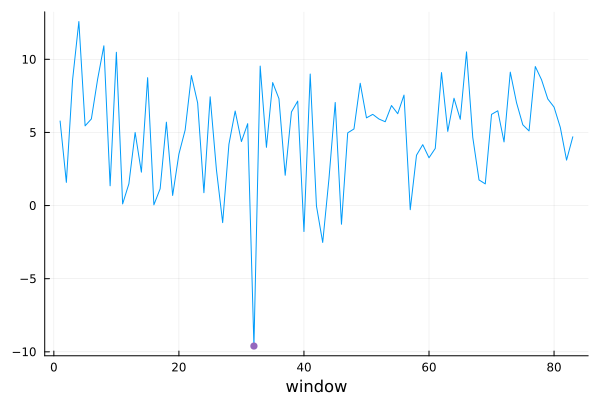

In [448]:
plot(probas, label="")
scatter!([argmin(probas)], [minimum(probas)], label="", msw=0, c=palette(:tab10)[5], xlabel="window")